# Variational quantum classifier

The variational quantum classifier (VQC) is a type of supervised quantum machine learning algorithm. Given a set of labeled training data consisting of features $X$ and associated labels $y$, the idea is to design a quantum model 
that learns to output an accurate guess for the label, based on a given set of input features.

<img src="fig/vqc.png" style="width: 600px">

There is a lot of flexibility and choice involved in constructing a classifier:

 1. how does the data get embedded?
 2. what variational circuit architecture should we use?
 3. how should we process the output measurements to determine the label?

## Data set analysis

In [1]:
from parse_vqc_data import parse_input
import matplotlib.pyplot as plt

X_train, Y_train, X_test, Y_test = parse_input()

In [2]:
X_train[:5]

tensor([[ 0.46586604,  0.47378893,  0.22608081],
        [ 0.32045034,  0.26276939,  0.12634708],
        [-0.2470099 ,  0.11383845,  0.14686661],
        [-0.39945595,  0.12837791,  0.16662385],
        [-0.33023235, -0.12453634,  0.19838102]], requires_grad=False)

In [3]:
Y_train[:10]

tensor([-1, -1,  0,  0,  0,  1, -1,  1,  0,  1], requires_grad=False)

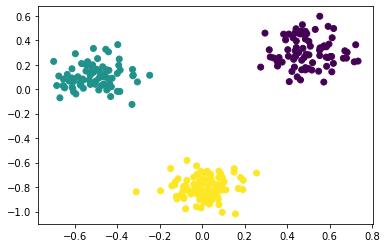

In [4]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)

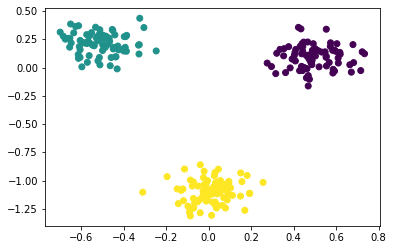

In [5]:
plt.scatter(X_train[:,0], X_train[:,2], c=Y_train)

## 0. Initial decisions based on the data

 - The data is 3-dimensional; let's use 3 qubits
 - We need to design parts of a quantum circuit to input data, and a section that uses trainable parameters
 - The output of the quantum circuit needs to turned into a meaningful cost.
 
That means our circuit/QNode is going to have the following signature/return type

```python
def circuit(x, params):
    ...
    return qml.expval(...)
```

In [6]:
import pennylane as qml
from pennylane import numpy as np

np.random.seed(0)

dev = qml.device('default.qubit', wires=3)

## 1. How does the data get embedded?

Straightforward method: rotate each qubit by a certain amount based on the data.

In [7]:
def load_data(x):
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.RX(x[2], wires=2)

PennyLane offers many built-in [templates](https://pennylane.readthedocs.io/en/stable/introduction/templates.html#embedding-templates) for embedding. This particular one is actually the `AngleEmbeddingTemplate` so we'll use that instead for brevity.

In [8]:
def load_data(x):
    qml.templates.AngleEmbedding(x, wires=[0, 1, 2])

## 2. What variational circuit architecture should we use?

Takes a bit of intuition and trial and error to determine works well for a given type of data. In general, the structures are repeated layers of rotations followed by a layer of entangling gates to scramble things up. PennyLane has many [layer templates](https://pennylane.readthedocs.io/en/stable/introduction/templates.html#layer-templates) to choose from for this. We will try the basic entangler layers:

<img src="fig/basic_entangler.png" width=400>

In [9]:
def variational_architecture(params):
    qml.templates.BasicEntanglerLayers(params, wires=[0, 1, 2])

The shape of the input parameters inform the template how large a circuit to make.

Let's take a look at a sample version of our circuit:

In [10]:
@qml.qnode(dev)
def circuit(x, params):
    load_data(x)
    variational_architecture(params)
    return qml.expval(qml.PauliZ(wires=0)) # Placeholder for now

In [11]:
params = np.random.normal(size=(2, 3))

In [12]:
circuit(X_train[0], params)

tensor(-0.05852758, requires_grad=True)

In [13]:
print(qml.draw(circuit)(X_train[0], params))

 0: ──RX(0.466)──RX(1.76)───╭C────────────────╭X──RX(2.24)────╭C──────╭X──┤ ⟨Z⟩ 
 1: ──RX(0.474)──RX(0.4)────╰X──╭C──RX(1.87)──│───────────────╰X──╭C──│───┤     
 2: ──RX(0.226)──RX(0.979)──────╰X────────────╰C──RX(-0.977)──────╰X──╰C──┤     



## 3. Mapping circuit outputs to labels

We can see from our data that there are 3 distinct labels: -1, 0, and 1.

Expectation values (the outputs of measurements) have value between [-1, 1]. Let's quantify the distance between the output and the true label and use this as the cost (we'll use a least-squares cost here).

In [14]:
def loss(Y_pred, Y_true):
    return np.sum((Y_pred - Y_true)**2) / len(Y_pred)

def cost(params, X, Y):
    predictions = [circuit(x, params) for x in X]
    return loss(np.array(predictions), Y)

def predict_label(output):
    if output > 0.33:
        return 1
    elif output < -0.33:
        return -1
    return 0
        
def accuracy(Y_pred, Y_true):
    predictions = []
    
    for output in Y_pred:
        predictions.append(predict_label(output))
    
    return sum(predictions == Y_true) / len(predictions)

## Running the VQC

In [15]:
n_layers = 3
init_params = np.random.uniform(size=(n_layers, 3))

opt = qml.optimize.GradientDescentOptimizer(stepsize=0.1)
batch_size = 5
params = init_params.copy()
num_its = 50

for it in range(num_its):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    params = opt.step(lambda v: cost(v, X_batch, Y_batch), params)

    if it % 5 == 0:
        Y_pred = [circuit(x, params) for x in X_train]
        acc = accuracy(Y_pred, Y_train)

        print(f"Step {it} training acc = {acc}")

Step 0 training acc = 0.168
Step 5 training acc = 0.636
Step 10 training acc = 0.68
Step 15 training acc = 0.964
Step 20 training acc = 0.98
Step 25 training acc = 1.0
Step 30 training acc = 1.0
Step 35 training acc = 1.0
Step 40 training acc = 1.0
Step 45 training acc = 1.0


In [16]:
predictions = [predict_label(circuit(x, params)) for x in X_test]

accuracy(predictions, Y_test)

tensor(1., requires_grad=False)

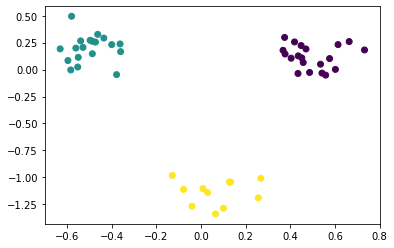

In [17]:
plt.scatter(X_test[:,0], X_test[:,2], c=predictions)

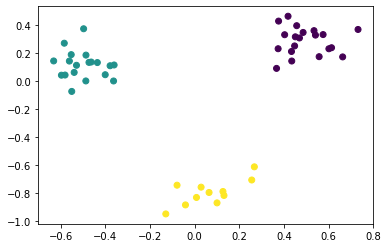

In [18]:
plt.scatter(X_test[:,0], X_test[:,1], c=predictions)

## Things for you to try:

 - a different data set
 - different methods to encode the data
 - different layer templates
 - different number of parameters in the layer templates
 - a different type of measurement or different observable